In [6]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import category_encoders as ce

from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import os
sns.set_theme(style="darkgrid")

path = os.path.dirname(os.getcwd()).replace('\\', '/') + '/'


import warnings
warnings.simplefilter("ignore", UserWarning)

warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)

In [7]:
hotels_data = pd.read_csv(path + 'data_set\hotels.csv')

# Подсчитываем количество дубликатов и удаляем их 
print(f'Количество дубликатов составляет: {hotels_data.duplicated().sum()}')
hotels_data.drop_duplicates()


Количество дубликатов составляет: 307


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.2,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.3,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066


In [8]:
hotels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

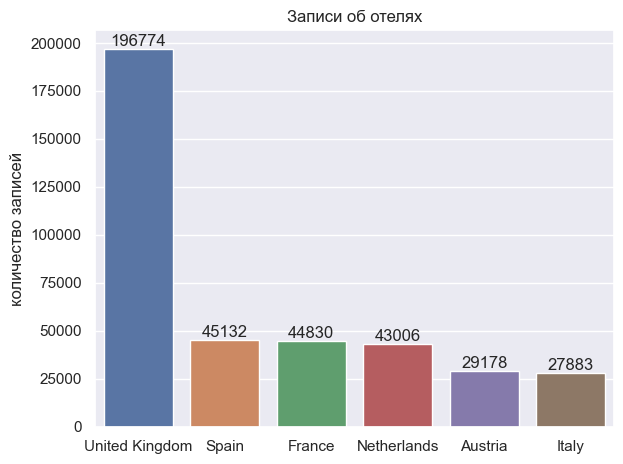

In [9]:
# Записываем категориальные признаки в отдельный датафрейм
ObjDataHotel = hotels_data[['hotel_address', 'hotel_name', 
                            'reviewer_nationality', 'negative_review', 
                            'positive_review', 'tags', 'days_since_review']]



# Из признака 'hotel_address' мы можем извлечь название страны
ObjDataHotel['hotel_country'] = \
    ObjDataHotel['hotel_address'].apply(lambda x: x.split(' ')[-2:]) 
    
    
    
ObjDataHotel['hotel_country'] = \
    ObjDataHotel['hotel_country'].apply(lambda x: x[1] if x[0] != 'United' and \
        x[1] != 'Kingdom' else 'United Kingdom')
    
# Судя по всему в датафрейме указаны только столичные отели, поэтому 
# извлекать название города в отдельную переменную нет необходимости    
    
    
# Подсчитываем количество записей об отелях по странам и выводим ввиде барплота
HotelCntry_count = ObjDataHotel['hotel_country'].value_counts().to_frame()

HotelCntry_count.reset_index().rename(columns={'hotel_country':'hotel_country'})

HotelCntry_bar = sns.barplot(data=HotelCntry_count, x='hotel_country', 
                             y='count', hue='hotel_country', palette='deep',
                             errorbar=None)

HotelCntry_bar.set(title='Записи об отелях', 
                   ylabel='количество записей', xlabel='')


for i in HotelCntry_bar.containers:
    HotelCntry_bar.bar_label(i)
    
plt.tight_layout()


# Так как количество стран невелико (ниже 15) можно их закодировать с помощью 
# Ordinary Encoder
HotelCntry_dummies = pd.get_dummies(ObjDataHotel['hotel_country'], dtype=int)

In [10]:
# Оцениваем количество уникальных значений в признаке 'hotel_name'
print(f"Количество уникальных значений {ObjDataHotel['hotel_name'].nunique()}")


# Кодируем эту переменную с помощью Binary Encoder 
# так как уникальных значений значительно выше 15
BinEncoder = ce.BinaryEncoder(cols=['hotel_name'])
BinHotlname = BinEncoder.fit_transform(ObjDataHotel['hotel_name'])
BinHotlname

Количество уникальных значений 1492


,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
386798,0,1,0,1,1,1,0,1,0,1,1
386799,0,0,1,0,1,0,1,0,0,1,1
386800,0,0,1,1,0,0,0,0,1,0,0
386801,0,0,1,0,0,1,1,0,0,0,0


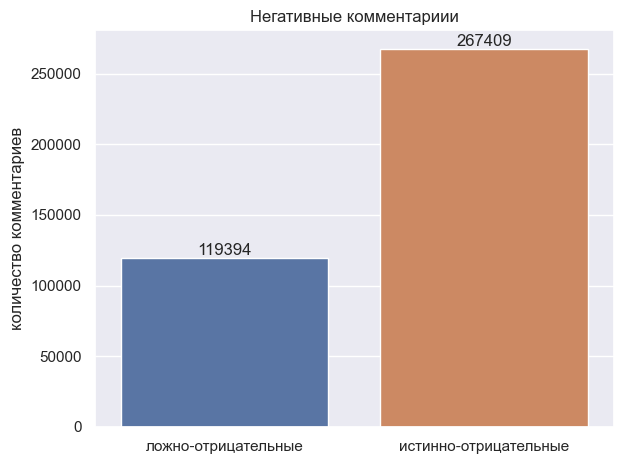

In [11]:
# Записываем категориальные признаки в отдельный датафрейм
ObjDataHotel = hotels_data[['hotel_address', 'hotel_name', 
                            'reviewer_nationality', 'negative_review', 
                            'positive_review', 'tags', 'days_since_review']]


# Приводим все строки в переменной 'negative_review' к нижнему регистру
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: x.lower())

# Выбираем топ 75 коментариев, среди которых ложно-отрицательные
# (по типу "No negative" или "nothing") будут всречаться наиболее часто
NonNegList = ObjDataHotel['negative_review'].value_counts()\
    .nlargest(75).to_frame().reset_index()



# Среди этого топа комментариев выбираем ключевые слова, которые ассоциированы
# с истинно-отрицательными комментариями по типу "bad wifi" 
Try_neg_lst = ['room', 'rooms','leaving', 'leave', 
               'applicable', 'parking', 'gym', 'staff',
               'wi', 'fi', 'wifi', 'wi-fi', 'breakfast', 'expensive', 
               'location', 'price', 'pillows', 'bathroom']


# Создаем функцию, которая будет заменять истинно-отрицательные комментарии на None
# дополнительно убрает пробелы
def CompareToLst(lst): 
    IntersecLst = list(set(lst).intersection(Try_neg_lst))
    if len(IntersecLst) > 0:
        return 
    else:
        return ''.join(lst)
    
    
# Удаляем истинно-отрицательные комментарии
NonNegList['negative_review'] = \
    NonNegList['negative_review'].apply(lambda x: x.split(' ') \
        if x != ' ' else list(x))

NonNegList['negative_review'] = \
    NonNegList['negative_review'].apply(CompareToLst)
        
NonNegList.dropna(inplace=True)

NonNegList = NonNegList['negative_review'].tolist()
NonNegList


# Удаляем пробеды из признака 'negative_review'
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: ''.join(x.split(' ')))
    

# Заменяем ложно-негативные на 0, истинно негативные на 1
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: 0 if x in NonNegList else 1)
    
    
    
# Выводим в виде барплота    
HotelCntry_count = ObjDataHotel['negative_review'].value_counts().to_frame()

HotelCntry_count.reset_index()

HotelCntry_bar = sns.barplot(data=HotelCntry_count, x='negative_review', 
                             y='count', hue='negative_review', palette='deep',
                             errorbar=None, legend=False)

HotelCntry_bar.set(title='Негативные комментариии', 
                   ylabel='количество комментариев', xlabel='',
                   xticklabels=['ложно-отрицательные', 'истинно-отрицательные'])


for i in HotelCntry_bar.containers:
    HotelCntry_bar.bar_label(i)
    
plt.tight_layout()

In [13]:
hotels_data['positive_review'].value_counts().nlargest(50)

positive_review
No Positive                    26885
 Location                       6833
 Everything                     1697
 location                       1251
 Nothing                         931
 The location                    830
 Great location                  809
 Good location                   690
 Location                        663
 Breakfast                       455
 Everything                      449
 Friendly staff                  385
 Staff                           347
 Excellent location              296
 Great location                  280
 Location and staff              256
 everything                      233
 Good location                   214
 Nothing                         170
 nothing                         159
 Comfy bed                       158
 The location                    152
 The staff                       151
 good location                   151
 the location                    141
 Location was good               140
 Location was great   

In [ ]:
hotels_data['review_date'] = pd.to_datetime(hotels_data['review_date'])
hotels_data['review_date']




0        2016-02-19
1        2017-01-12
2        2016-10-18
3        2015-09-22
4        2016-03-05
            ...    
386798   2017-04-19
386799   2017-02-13
386800   2016-02-07
386801   2017-05-21
386802   2016-08-05
Name: review_date, Length: 386803, dtype: datetime64[ns]